# Applied Stochastic Process - Group Project

**Author:** *Jiahao Yu, Bo Sun* 

**Instructor**: *Jaehyuk Choi*

In [96]:
%load_ext autoreload
%autoreload 2

import time
import scipy as sp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import sys
sys.path.insert(sys.path.index('')+1, r'C:\Users\harvey\Documents\GitHub\PyFENG')
import pyfeng as pf
import pyfeng.ex as pfex
from pyfeng import garch_2
from scipy import interpolate, integrate
import seaborn as sns

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Contents

<div class="toc"><ul class="toc-item"><li><span><a href="#Part-I:-Approximation-Methods-for-Inhomogeneous-Geometric-Brownian-Motion" data-toc-modified-id="Part-I:-Approximation-Methods-for-Inhomogeneous-Geometric-Brownian-Motion-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Part I: Approximation Methods for Inhomogeneous Geometric Brownian Motion</a></span><ul class="toc-item"><li><span><a href="#GARCH-Diffusion-Process" data-toc-modified-id="GARCH-Diffusion-Process-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>GARCH Diffusion Process</a></span></li><li><span><a href="#Modification-Term-$W(x,-x_0,-T)$" data-toc-modified-id="Modification-Term-$W(x,-x_0,-T)$-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Modification Term $W(x, x_0, T)$</a></span></li><li><span><a href="#Transition-Density:-$\rho(x,-T|x_0,-0)-\rightarrow-\rho(y,-T|y_0,-0)$" data-toc-modified-id="Transition-Density:-$\rho(x,-T|x_0,-0)-\rightarrow-\rho(y,-T|y_0,-0)$-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Transition Density: $\rho(x, T|x_0, 0) \rightarrow \rho(y, T|y_0, 0)$</a></span></li><li><span><a href="#Generate-RNs-(variances-paths)" data-toc-modified-id="Generate-RNs-(variances-paths)-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Generate RNs (variances paths)</a></span><ul class="toc-item"><li><span><a href="#Generate-RNs-at-time-T" data-toc-modified-id="Generate-RNs-at-time-T-2.4.1"><span class="toc-item-num">2.4.1&nbsp;&nbsp;</span>Generate RNs at time T</a></span></li><li><span><a href="#Variances-of-n_paths-at-time-T" data-toc-modified-id="Variances-of-n_paths-at-time-T-2.4.2"><span class="toc-item-num">2.4.2&nbsp;&nbsp;</span>Variances of n_paths at time T</a></span></li></ul></li><li><span><a href="#Simulates-Option-Prices" data-toc-modified-id="Simulates-Option-Prices-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>Simulates Option Prices</a></span></li><li><span><a href="#Variance-Comparison-on-the-Simulated-Option-Price" data-toc-modified-id="Variance-Comparison-on-the-Simulated-Option-Price-2.6"><span class="toc-item-num">2.6&nbsp;&nbsp;</span>Variance Comparison on the Simulated Option Price</a></span></li></ul></li></ul></li></ul></li></ul></div>

- [Part II: Different numerical methods for the inhomogeneous geometric Brownian motion](#Part-II:-Different-numerical-methods-for-the-inhomogeneous-geometric-Brownian-motion)
    - [2.1 The IGBM and its properties](#2.1-The-IGBM-and-its-properties)
        - [2.1.1 Limit of the process](#2.1.1-Limit-of-the-process)
        - [2.1.2 Conditional and asymptotic mean and variance](#2.1.2-Conditional-and-asymptotic-mean-and-variance)
    - [2.2 Numerical methods for the IGBM](#2.2-Numerical-methods-for-the-IGBM)
        - [2.2.1 Itô -Taylor expansion approach](#2.2.1-Itô-Taylor-expansion-approach)
        - [2.2.2 Splitting approach](#2.2.2-Splitting-approach)
        - [2.2.3. ODE approach](#2.2.3.-ODE-approach)
        - [2.1.2 Conditional and asymptotic mean and variance](#2.1.2-Conditional-and-asymptotic-mean-and-variance)
    - [2.3 Conditional States](#2.3-Conditional-States)
    - [2.4 Biases of conditional mean and variance](#2.4-Biases-of-conditional-mean-and-variance) 
    - [2.5 Monte-Carlo Biases of conditional mean and variance](#2.5-Monte-Carlo-Biases-of-conditional-mean-and-variance) 
    - [2.6 Comparing Different Schemes in Option Pricing](#2.6-Comparing-Different-Schemes-in-Option-Pricing)
        - [2.6.1 Different time to expiry, n_path = 1000](#2.6.1-Different-time-to-expiry,-n_path-=-1000)
        - [2.6.2 Different  initial sigma, n_path = 1000](#2.6.2-Different-initial-sigma,-n_path-=-1000)
        - [2.6.3 Different strikes, n_path = 1000](#2.6.3-Different-strikes,-n_path-=-1000)
        - [2.6.4 Convergence Speed](#2.6.4-Convergence-Speed)
        - [2.6.5 Executing Time, n_path = 1000](#2.6.5-Executing-Time,-n_path-=-1000)

# Part I: Approximation Methods for Inhomogeneous Geometric Brownian Motion

Capriotti, L., Jiang, Y., & Shaimerdenova, G. (2019). Approximation methods for inhomogeneous geometric Brownian motion. $International\ Journal\ of\ Theoretical\ and\ Applied\ Finance$, $\textit{22}$(02), 1850055.

## GARCH Diffusion Process

The basic GARCH Diffusion process, say IGBM, is following:

$$
\begin{align*}
    &dS_t = \mu dt + \sqrt{Y_t}dW_t \\
    &dY_t = a(b-Y_t)dt + \sigma Y_tdB_t \label{eq1.2}\tag{1.2} \\
    &\qquad where\ dW_tdB_t = \rho dt &
\end{align*}
$$

To simplify it, this paper uses the trasformation and applies the Ito' lemma to it as following:

$$
\begin{align*}
    &X_t = \gamma(Y_t) \equiv \sigma \int_0^{Y_t}\frac{dy}{\sigma y} = ln(Y_t) \label{eq2.1}\tag{2.1} \\
    \Rightarrow &dX_t = \mu_x(X_t)dt + \sigma dB_t \label{eq2.2}\tag{2.2}
\end{align*}
$$

$$
\begin{align*}
   \qquad where\ \mu_x(x) &= \sigma \left[ \frac{\mu_y(\gamma^{-1}(x))}{\sigma_y(\gamma^{-1}(x))} - 
    \frac{1}{2}\frac{\partial{\sigma_y}}{\partial{y}}(\gamma^{-1}(x)) \right] & \label{eq2.3}\tag{2.3} \\
                   &= abe^{-x} - (a+ \frac{1}{2}\sigma^2)
\end{align*}
$$

The transition probabilities for the processes (Xt) and (Yt) are related by the Jacobian associated with $\eqref{eq2.1}$ giving

$$
\begin{align*}
    &\rho_y(0, t, y_0, y) = \sigma \frac{\rho(0, t, x_0, \gamma(y))}{\sigma y} & \label{eq2.4}\tag{2.4}
\end{align*}
$$

In order to find an expression for the transition probabilities associated with Eq.$(2.2)$, which is accurate for a time T as long as possible, this paper makes the ansatz

$$
\begin{align*}
    &\rho(0, T, x_0, x) = \frac{1}{\sqrt{2\pi\sigma^2T}}exp\left [ -\frac{(x-x_0)^2}{2\sigma^2 T} 
    - W(x, x_0, T) \right ] & \label{eq2.5}\tag{2.5}
\end{align*}
$$

## Modification Term $W(x, x_0, T)$

According to Kolmogorov forward equation:

$$
\begin{align*}
    &\partial_t{\rho(0, T, x_0, x)} = \left [ -\partial_x{\mu_x(x)} + \frac{1}{2}\sigma^2\partial_x^2 \right ] 
    \rho_x(0, T, x_0, x) & \label{eq2.6}\tag{2.6}
\end{align*}
$$

Substitue the $(2.5)$ to $\eqref{eq2.6}$:

$$
\begin{align*}
    &\partial_t W = -\mu_x \partial_x W + \frac{1}{2}\sigma^2\partial_x^2 W - \frac{1}{2}\sigma^2(\partial_x W)^2 
    + \partial_x \mu_x - \frac{x-x_0}{T}(\partial_xW + \frac{\mu_x}{\sigma^2}) & \label{eq2.7}\tag{2.7}
\end{align*}
$$

It is difficult to solve this PDE. 

So this paper uses exponential expansion to obtain the approximate $W$:

$$
\begin{align*}
        & W(x, x_0, T) = \sum_{n=0}^{\infty}{W_n(x, x_0)T^n} \label{eq2.8}\tag{2.8}\\
        & W_0(x, x_0) = -\frac{1}{\sigma^2}\int_{x_0}^{x}{\mu_x(z)dz}& \label{eq2.9}\tag{2.9}
\end{align*}
$$

Substituting $\ref{eq2.8}$ to (2.7) and comparing the coefficients of $T^n$, this paper gets: 

$$
\begin{align*}
        & nW_n(x, x_0) = -(x-x_0)\partial_x{W_n(x, x_0)} + \Lambda_{n-1}(x, x_0) \label{eq2.11}\tag{2.11}&
\end{align*}
$$

$$
\begin{align*}
    where\\
    \Lambda_{n-1}(x, x_0) &= \left[ -\frac{1}{2}\sigma^2\partial_x^2 - \mu_x\partial_x \right] W_{n-1} - 
    \frac{1}{2}\sigma^2\sum_{m=0}^{m=n-1}{\partial_xW_m \partial_xW_{n-1-m}} + \delta_{n-1,0}\partial_x\mu_x \\
    \delta_{n-1,0} &= 
    \begin{cases}
        1, n=1 \\
        0, n\neq 1
    \end{cases}
\end{align*}
$$

Then integrate $\ref{eq2.11}$, we have the final solution:

$$
\begin{align*}
        & W_n(x, x_0) = \int_0^1 \xi^{n-1}\Lambda_{n-1}(x_0+(x-x_0)\xi, x_0)d\xi \label{eq2.12}\tag{2.12}&
\end{align*}
$$

**Notice:**

The formula of $W_n$ contains the denominator of ($x-x_0$), which means that the expansion formula can not obtain the value at $x=x_0$. 

But we still notice that from (2.11), the $x=x_0$ would eliminate the term $\partial_xW_n(x, x_0)$, then the final formula has no demoninator of ($x-x_0$):

$$
\begin{align*}
        & nW_n(x, x_0) = \Lambda_{n-1}(x, x_0) &
\end{align*}
$$

In our experiment, we use this formula to calculate the $W_n(x, x_0)$ at $|x-x_0|<1e^{-3}$.

In [104]:
def plot_figure(z1=None, z2=None, f1=None, f2=None, 
                z1_name: str='z1', z2_name: str='z2', f1_name: str='f1', f2_name: str='f2', 
                bench_1=None, bench1_name=None, bench_2=None, bench2_name=None):
    plt.rcParams['figure.autolayout'] = True
    if z2 is None:
        fig, ax = plt.subplots()
        ax.plot(z1, f1, label=f1_name)
        if bench_1 is not None:
            ax.plot(z1, bench_1, color='red', label=bench1_name)
        if bench_2 is not None:
            ax.plot(z1, bench_2, color='yellow', label=bench2_name)
        ax.set_title('Order n = {:.0f}'.format(order))
        ax.set_xlabel(z1_name)
        ax.set_ylabel(f1_name)
        ax.legend()
        ax.grid()
        plt.tight_layout()
    else:
        fig, ax = plt.subplots(2, 1, figsize=(7,4.8))
        ax1 = ax[0]
        ax2 = ax[1]

        ax1.plot(z1, f1)
        ax1.set_title('Order n = {:.0f}'.format(order))
        ax1.set_xlabel(z1_name)
        ax1.set_ylabel(f1_name)
#         ax1.tick_params(labelsize=9)
        ax1.grid()

        ax2.plot(z2, f2)
        ax2.set_xlabel(z2_name)
        ax2.set_ylabel(f2_name)
#         ax2.tick_params(labelsize=9)
        ax2.grid()
        plt.tight_layout()

In [105]:
# initial params
a = 0.1
b = 0.04
vov = 0.6
y0 = 0.06
x0 = np.log(y0)
T = 1.0

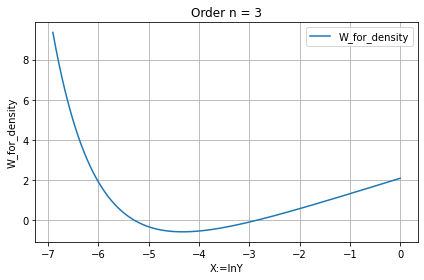

In [106]:
num = 10000
order = 3
yvals = np.r_[np.linspace(0.001, y0-0.002, num), np.linspace(y0+0.002, 1, num)]
xvals = np.log(yvals)

w_density = garch_2.w_for_density(mr=a, theta=b, vov=vov, x=xvals, x0=np.log(y0), t=T, n=order)
# w_density = garch_2.w_at_x0(mr=a, theta=b, vov=vov, x=xvals, t=0.05)

plot_figure(z1=xvals, f1=w_density, z1_name='X:=lnY', f1_name= 'W_for_density')

## Transition Density: $\rho(x, T|x_0, 0) \rightarrow \rho(y, T|y_0, 0)$

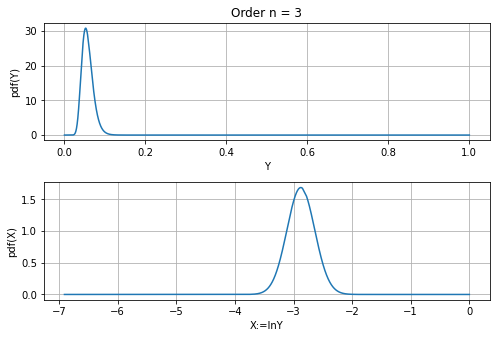

In [107]:
volmodel = garch_2.GarchCapriotti2018(mr=a, theta=b, vov=vov, rho=0.6, sigma_0=np.sqrt(y0), n_path=1000)
density_x = volmodel._transition_density_logvar(x=xvals, x0=x0, t=T, n=order)
density_y = volmodel.transition_density_var(var_t=yvals, var_0=y0, t=T, n=order)
plot_figure(yvals, xvals, density_y, density_x, 'Y', 'X:=lnY', 'pdf(Y)', 'pdf(X)')

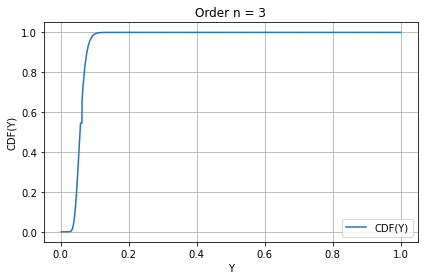

In [108]:
# Cumulated Density Function (CDF)
prob = np.zeros(yvals.size)
for i in range(100, yvals.size):
    prob[i] = integrate.simps(density_y[:i], yvals[:i])
plot_figure(z1=yvals, f1=prob, z1_name='Y', f1_name='CDF(Y)')

## Generate RNs (variances paths)

### Generate RNs at time T

In [109]:
def plot_freq_rn(rv, pdf_y, y):
    fig, ax = plt.subplots(2, 1)
    ax1 = ax[0]
    ax2 = ax[1]
    sns.distplot(rv, rug=True, norm_hist=True, ax=ax1, axlabel='rv Y', label='freq(Y)')
    ax1.legend()
    ax1.grid()

    ax2.plot(y, pdf_y)
    ax2.set_xlabel('rv Y')
    ax2.set_ylabel('pdf(Y)')
    ax2.grid()

C:\Users\harvey\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\harvey\anaconda3\lib\site-packages\seaborn\distributions.py:2056: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


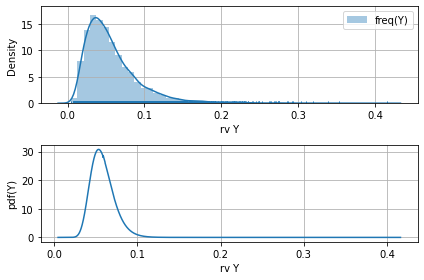

In [110]:
rv = volmodel.rv(t=T, var_0=y0*np.ones(num))
rv_theory = np.r_[np.linspace(rv.min(), y0-0.001, num//2), np.linspace(y0+0.001, rv.max(), num//2)]
pdf_theory = volmodel.transition_density_var(var_t=rv_theory, var_0=y0, t=T, n=order)
plot_freq_rn(rv, pdf_theory, rv_theory)

### Variances of n_paths at time T

In [112]:
var_T,_,_,_ = volmodel.cond_states(var_0=y0, texp=T)

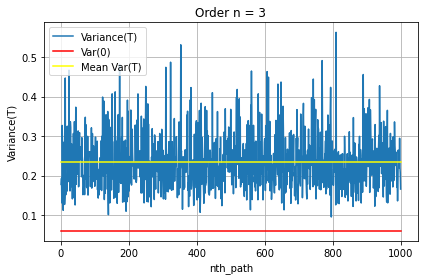

In [113]:
plot_figure(z1=np.arange(1, var_T.size+1), f1=var_T, 
            z1_name='nth_path', f1_name='Variance(T)', 
            bench_1=y0*np.ones(var_T.size), bench1_name='Var(0)',
            bench_2=var_T.mean()*np.ones(var_T.size), bench2_name='Mean Var(T)')

## Simulates Option Prices

In [114]:
%%time
volmodel.price(strike=110, spot=100, texp=T)

Wall time: 1.48 s


15.729733767384097

In [ ]:
%%time
# notice: one loop for pricing costs 2.8s or so.
num_p = 100
p = np.zeros(num_p)
for k in range(num_p):
    p[k] = volmodel.price(strike=110, spot=100, texp=T)

In [ ]:
p

In [ ]:
print("\
    Capriotti method's results under {} loops costing {},rho={:.2f} \n \
      Mean Prices:{:.6f}\n \
      Variance:   {:.6f}\n \
      Std. Err.: {:.4%}\
      ".format(num_p,'4min 48s',volmodel.rho,p.mean(), p.var(), p.std())
     )

## Variance Comparison on the Simulated Option Price

In [ ]:
%%time
num_p = 10000
garch_uncor = garch_2.GarchUncorrBaroneAdesi2004(sigma=np.sqrt(y0), mr=a, theta=b, vov=vov)
p_uncor = np.zeros(num_p)

for k in range(num_p):
    p_uncor[k] = garch_uncor.price(strike=110, spot=100, texp=T)

In [ ]:
print("\
    BaroneAdesi Uncorrelated MC Results under {} loops costing {} \n \
      Mean Prices:{:.6f}\n \
      Variance:   {:.6f}\n \
      Std. Err.: {:.4%}\
      ".format(num_p,'45.8 ms',p_uncor.mean(), p_uncor.var(), p_uncor.std())
     )

# Part II: Different numerical methods for the inhomogeneous geometric Brownian motion

*This part is a replication of the paper [Qualitative properties of numerical methods for the inhomogeneous geometric Brownian motion](./QualitativeIGBM.pdf).*

*[1] Tubikanec I, Tamborrino M, Lansky P, et al. Qualitative properties of numerical methods for the inhomogeneous geometric Brownian motion[J]. arXiv preprint arXiv:2003.10193, 2020.*

## 2.1 The IGBM and its properties

The IGBM is described by the Itô SDE

$$
\begin{equation}
d Y(t)=\underbrace{\left(-\frac{1}{\tau} Y(t)+\mu\right)}_{:=F(Y(t))} d t+\underbrace{\sigma Y(t)}_{:=G(Y(t))} d W(t), \quad t \geq 0, \quad Y(0)=Y_{0}, \tag{1}
\end{equation}
$$

where $\tau, \sigma>0, \mu \in \mathbb{R}$ and $W=(W(t))_{t \geq 0}$ is a standard Wiener process defined on the probability space $(\Omega, \mathcal{F}, \mathbb{P})$ with a filtration $\mathcal{F}=(\mathcal{F}(t))_{t \geq 0}$ generated by $W$. The initial value $Y_{0}$ is either a deterministic non-negative constant or an $\mathcal{F}(0)$-measurable non-negative random variable with finite second moment. Since (1) is a linear and autonomous SDE, a unique strong solution process $Y=(Y(t))_{t \geq 0}$ exists. The solution of the homogeneous SDE (if $\left.\mu=0\right)$ corresponds to the well-known GBM. The solution of the inhomogeneous equation can be expressed in terms of the embedded GBM. In particular, applying the variation of constants formula to (1) yields

$$
\begin{equation}
Y(t)=e^{-\left(\frac{1}{\tau}+\frac{\sigma^{2}}{2}\right) t+\sigma W(t)}\left(Y_{0}+\mu \int_{0}^{t} e^{\left(\frac{1}{\tau}+\frac{\sigma^{2}}{2}\right) s-\sigma W(s)} d s\right) . \tag{2}
\end{equation}
$$

### 2.1.1 Limit of the process

Since $\tau>0$, and thus $1 / \tau+\sigma^{2} / 2>0$, the limit of the process (2) (for $t \rightarrow \infty$ ), denoted by $Y_{\infty}$, exists almost surely and its distribution does not depend on $Y_{0}$ [2], see Section $5.3$ for a description of the limit distribution when $\mu>0$. If $\mu=0$, the process $Y_{\infty}$ degenerates to the origin 0 almost surely. In the context of linear stability analysis, this means that the equilibrium solution 0 of (1) is asymptotically stable.

### 2.1.2 Conditional and asymptotic mean and variance

Since $Y_{0}$ has finite second moment, the mean and variance of the process $Y$, conditioned on the initial value $Y_{0}$, exist. They are explicitly known and given by

$$
\begin{equation}
\begin{aligned}
\mathbb{E}\left[Y(t) \mid Y_{0}\right]=& Y_{0} e^{-\frac{1}{\tau} t}+\mu \tau\left(1-e^{-\frac{1}{\tau} t}\right)
\end{aligned} \tag{3}
\end{equation}
$$

$$
\begin{equation}
\begin{aligned}
\operatorname{Var}\left(Y(t) \mid Y_{0}\right)=&\left\{\begin{array}{lr}
e^{-\frac{1}{\tau} t}\left(2 \mu\left[t Y_{0}-\tau Y_{0}-t \mu \tau\right]+Y_{0}^{2}\right)-e^{-\frac{2}{\tau} t}\left(Y_{0}-\mu \tau\right)^{2}+(\mu \tau)^{2}, & \text { if } \sigma^{2} \tau=1, \\
e^{-\frac{1}{\tau} t}\left(4 \mu \tau\left[\mu \tau-Y_{0}\right]\right)-e^{-\frac{2}{\tau} t}\left(Y_{0}-\mu \tau\right)^{2}+2 \mu^{2} \tau t-3(\mu \tau)^{2}+2 \mu \tau Y_{0}+Y_{0}^{2}, & \text { if } \sigma^{2} \tau=2, \\
\frac{(\mu \tau)^{2} \sigma^{2} \tau}{2-\sigma^{2} \tau}+2 \tau \sigma^{2} \frac{\left(Y_{0}-\mu \tau\right) \mu \tau}{1-\sigma^{2} \tau} e^{-\frac{1}{\tau} t}-e^{-\frac{2}{\tau} t}\left(Y_{0}-\mu \tau\right)^{2} \\
+e^{\left(\sigma^{2}-\frac{2}{\tau}\right) t}\left[Y_{0}^{2}-\frac{2 Y_{0} \mu \tau}{1-\sigma^{2} \tau}+\frac{2(\mu \tau)^{2}}{\left(2-\sigma^{2} \tau\right)\left(1-\sigma^{2} \tau\right)}\right], & \text { otherwise }.
\end{array}\right. 
\end{aligned} \tag{4}
\end{equation}
$$

Since $\tau>0$, from (3), it follows that the asymptotic mean of $Y$ exists. It is given by

$$
\mathbb{E}\left[Y_{\infty}\right]:=\lim _{t \rightarrow \infty} \mathbb{E}\left[Y(t) \mid Y_{0}\right]=\mu \tau . \tag{5}
$$

From (4), it follows that, under the condition $\sigma^{2} \tau<2$, the asymptotic variance of $Y$ exists. It is given by

$$
\operatorname{Var}\left(Y_{\infty}\right):=\lim _{t \rightarrow \infty} \operatorname{Var}\left(Y(t) \mid Y_{0}\right)=\frac{(\mu \tau)^{2}}{\frac{2}{\sigma^{2} \tau}-1} . \tag{6}
$$

**Note:** In the context of Garch-diffusion option pricing model, our SDE for $v_t$ is:

$$
\begin{equation}
dv_t = \kappa (\theta - v_t)dt + \nu v_t dZ_t
\end{equation}
$$

so the coefficient mapping from (1) to Garch-diffusion model is:
- $\kappa = \frac{1}{\tau}$ or $\tau = \frac{1}{\kappa}$
- $\theta = \mu\tau$ or $\mu = \kappa\theta$
- $\sigma = \nu$

In [97]:
class IGBM_theoretical():
    def __init__(self, mr, theta, vov):
        self.mr = mr
        self.theta = theta
        self.vov = vov
        
    def cond_mean(self, sigma_0, texp):
        # equation (3)
        coeff = np.exp(-self.mr*texp)
        sigma_t = sigma_0 *  coeff + self.theta * (1 - coeff)
        return sigma_t
        
    def cond_var(self, sigma_0, texp):
        # equation (4)
        coeff1 = self.vov**2 / self.mr
        coeff2 = np.exp(-self.mr*texp)
        if coeff1 == 1:
            var_t = coeff2 * (2*self.mr*self.theta*(texp*sigma_0 - sigma_0/self.mr - texp*self.theta) + sigma_0**2) \
                        - coeff2**2 * (sigma_0 - self.theta)**2 + self.theta**2
        elif coeff1 == 2:
            var_t = coeff2 * (4*self.theta*(self.theta-sigma_0)) - coeff**2 * (sigma_0 - self.theta)**2 + 2*self.theta**2*self.mr*texp \
                        - 3 * self.theta**2 + 2 * self.theta * sigma_0 + sigma_0**2
        else:
            var_t = self.theta**2 * coeff1 / (2 - coeff1) + 2 * coeff1 * (sigma_0 - self.theta) * self.theta / (1 - coeff1) * coeff2 \
                        - coeff2**2 * (sigma_0 - self.theta)**2 + np.exp((self.vov**2-2*self.mr)*texp) \
                        * (sigma_0**2 - 2 * sigma_0 * self.theta / (1-coeff1) + 2 * self.theta**2 / (2 - coeff1) / (1 - coeff1))
        return var_t

## 2.2 Numerical methods for the IGBM

Consider a discretised time interval $\left[0, t_{\max }\right], t_{\max }>0$, with equidistant time steps $\Delta=t_{i}-t_{i-1}, i=1, \ldots, N, N \in \mathbb{N}$, $t_{0}=0$ and $t_{N}=t_{\max }$. We denote by $\widetilde{Y}\left(t_{i}\right)$ a numerical realisation of the process $Y$ at the discrete time points $t_{i}=i \Delta$, where $\widetilde{Y}\left(t_{0}\right):=Y_{0}$. Moreover, we denote by $\xi_{i-1}:=W\left(t_{i}\right)-W\left(t_{i-1}\right) \sim N(0, \Delta), i=1, \ldots, N$, the Wiener increments which are independent and identically distributed (iid) normal random variables with null mean and variance $\Delta$. In the following, we recall different numerical methods used to generate values $\widetilde{Y}\left(t_{i}\right)$ of the IGBM.

### 2.2.1 Itô-Taylor expansion approach

The most popular approach to derive numerical methods for SDEs is to use appropriate truncations of the Itô-Taylor series expansion. Two of the most well-known methods in this class are the Euler-Maruyama and the Milstein schemes. 

#### 2.2.1.1 The Euler-Maruyama scheme

The Euler-Maruyama scheme yields trajectories of the IGBM through the iteration

$$
\widetilde{Y}^{\mathrm{E}}\left(t_{i}\right)=\widetilde{Y}^{\mathrm{E}}\left(t_{i-1}\right)+\Delta\left(-\frac{1}{\tau} \widetilde{Y}^{\mathrm{E}}\left(t_{i-1}\right)+\mu\right)+\sigma \widetilde{Y}^{\mathrm{E}}\left(t_{i-1}\right) \xi_{i-1} .\tag{7}
$$

This method is mean-square convergent of order $1 / 2$. 

#### 2.2.1.2 The Milstein scheme

The Milstein scheme yields trajectories of the IGBM via

$$
\widetilde{Y}^{\mathrm{M}}\left(t_{i}\right)=\widetilde{Y}^{\mathrm{M}}\left(t_{i-1}\right)+\Delta\left(-\frac{1}{\tau} \widetilde{Y}^{\mathrm{M}}\left(t_{i-1}\right)+\mu\right)+\sigma \widetilde{Y}^{\mathrm{M}}\left(t_{i-1}\right)\left(\xi_{i-1}+\frac{\sigma}{2}\left(\xi_{i-1}^{2}-\Delta\right)\right), \tag{8}
$$

and has a mean-square convergence rate of order 1.

### 2.2.2 Splitting approach

The second approach is based on splitting methods. A brief account of their key ideas is provided in the following. Consider an Itô SDE of the form

$$
d Y(t)=F(Y(t)) d t+G(Y(t)) d W(t), \quad t \geq 0, \quad Y(0)=Y_{0}, \tag{9}
$$

where the drift coefficient and the diffusion component can be expressed as

$$
F(Y(t))=\sum_{l=1}^{d} F^{[l]}(Y(t)), \quad G(Y(t))=\sum_{l=1}^{d} G^{[l]}(Y(t)), \quad d \in \mathbb{N} .\tag{10}
$$

Usually, there are several ways how to decompose the components $F$ and $G$. The goal is to obtain subequations

$$
d Y^{[l]}(t)=F^{[l]}\left(Y^{[l]}(t)\right) d t+G^{[l]}\left(Y^{[l]}(t)\right) d W(t), \quad l \in\{1, \ldots, d\},
$$

which can be solved explicitly. Once the explicit solutions are derived, they need to be composed. Two common procedures for doing this are the Lie-Trotter and the Strang approach. Let $\varphi_{t}^{[l]}\left(Y_{0}\right)$ denote the exact flows (solutions) of the subequations in (10) at time $t$ and starting from $Y_{0}$. Then, the Lie-Trotter composition of flows

$$
\widetilde{Y}\left(t_{i}\right)=\left(\varphi_{\Delta}^{[1]} \circ \ldots \circ \varphi_{\Delta}^{[d]}\right)\left(\widetilde{Y}\left(t_{i-1}\right)\right)
$$

and the Strang approach

$$
\widetilde{Y}\left(t_{i}\right)=\left(\varphi_{\Delta / 2}^{[1]} \circ \ldots \circ \varphi_{\Delta / 2}^{[d-1]} \circ \varphi_{\Delta}^{[d]} \circ \varphi_{\Delta / 2}^{[d-1]} \circ \ldots \circ \varphi_{\Delta / 2}^{[1]}\right)\left(\widetilde{Y}\left(t_{i-1}\right)\right)
$$

yield numerical methods for (9). The order of the evaluations of the exact flows can be changed, yielding different schemes within each approach.

#### 2.2.2.1 The Lie-Trotter schemes

With the purpose of excluding the inhomogeneous part, relying thus on the underlying GBM, we split (1) into two simple subequations, namely

$$
\begin{equation}
d Y^{[1]}(t)=\underbrace{-\frac{1}{\tau} Y^{[1]}(t)}_{F^{[1]}\left(Y^{[1]}(t)\right)} d t+\underbrace{\sigma Y^{[1]}(t)}_{G^{[1]}\left(Y^{[1]}(t)\right)} d W(t) \tag{11}
\end{equation}
$$

$$
\begin{equation}
d Y^{[2]}(t)=\underbrace{\mu}_{F^{[2]}} d t, \quad G^{[2]} \equiv 0 . \tag{12}
\end{equation}
$$

The first equation, corresponding to the GBM, allows for an exact simulation of sample paths through

$$
Y^{[1]}\left(t_{i}\right)=\varphi_{\Delta}^{[1]}\left(Y^{[1]}\left(t_{i-1}\right)\right)=Y^{[1]}\left(t_{i-1}\right) e^{-\left(\frac{1}{\tau}+\frac{\sigma^{2}}{2}\right) \Delta+\sigma \xi_{i-1}}, \quad i=1, \ldots, N . \tag{13}
$$

The second equation is a simple ODE with its explicit solution given by

$$
Y^{[2]}\left(t_{i}\right)=\varphi_{\Delta}^{[2]}\left(Y^{[2]}\left(t_{i-1}\right)\right)=Y^{[2]}\left(t_{i-1}\right)+\mu \Delta, \quad i=1, \ldots, N . \tag{14}
$$

The Lie-Trotter composition yields

$$
\begin{equation}
\widetilde{Y}^{\mathrm{L} 1}\left(t_{i}\right):=\left(\varphi_{\Delta}^{[1]} \circ \varphi_{\Delta}^{[2]}\right)\left(\widetilde{Y}^{\mathrm{L} 1}\left(t_{i-1}\right)\right)=e^{-\left(\frac{1}{\tau}+\frac{\sigma^{2}}{2}\right) \Delta+\sigma \xi_{i-1}}\left(\widetilde{Y}^{\mathrm{L} 1}\left(t_{i-1}\right)+\mu \Delta\right), \tag{15}
\end{equation}
$$

$$
\begin{equation}
\widetilde{Y}^{\mathrm{L} 2}\left(t_{i}\right):=\left(\varphi_{\Delta}^{[2]} \circ \varphi_{\Delta}^{[1]}\right)\left(\widetilde{Y}^{\mathrm{L} 2}\left(t_{i-1}\right)\right)=\widetilde{Y}^{\mathrm{L2}}\left(t_{i-1}\right) e^{-\left(\frac{1}{\tau}+\frac{\sigma^{2}}{2}\right) \Delta+\sigma \xi_{i-1}}+\mu \Delta, \tag{16}
\end{equation}
$$

#### 2.2.2.2 The Strang schemes

Similarly, the Strang approach results in

$$
\widetilde{Y}^{\mathrm{S} 1}\left(t_{i}\right):=\left(\varphi_{\Delta / 2}^{[2]} \circ \varphi_{\Delta}^{[1]} \circ \varphi_{\Delta / 2}^{[2]}\right)\left(\widetilde{Y}^{\mathrm{S} 1}\left(t_{i-1}\right)\right)=\left(\widetilde{Y}^{\mathrm{S} 1}\left(t_{i-1}\right)+\mu \frac{\Delta}{2}\right) e^{-\left(\frac{1}{\tau}+\frac{\sigma^{2}}{2}\right) \Delta+\sigma \xi_{i-1}}+\mu \frac{\Delta}{2}, \tag{17}
$$

$$
\widetilde{Y}^{\mathrm{S} 2}\left(t_{i}\right):=\left(\varphi_{\Delta / 2}^{[1]} \circ \varphi_{\Delta}^{[2]} \circ \varphi_{\Delta / 2}^{[1]}\right)\left(\tilde{Y}^{\mathrm{S} 2}\left(t_{i-1}\right)\right)=\widetilde{Y}^{\mathrm{S} 2}\left(t_{i-1}\right) e^{-\left(\frac{1}{\tau}+\frac{\sigma^{2}}{2}\right) \Delta+\sigma\left(\varphi_{i-1}+\psi_{i-1}\right)}+\mu \Delta e^{-\left(\frac{1}{\tau}+\frac{\sigma^{2}}{2}\right) \frac{\Delta}{2}+\sigma \psi_{i-1},}, \tag{18}
$$

with iid random variables $\varphi_{i-1}, \psi_{i-1} \sim N(0, \Delta / 2)$, representing independent Wiener increments of length $\Delta / 2$.

### 2.2.3. ODE approach

An alternative approach to derive numerical solutions of SDEs is to solve properly derived ODEs, a methodology that we briefly recall in the following. Consider the Stratonovich version of (9) given by

$$
d Y(t)=\bar{F}(Y(t)) d t+G(Y(t)) \circ d W(t), \quad t \geq 0, \quad Y(0)=Y_{0}, \tag{19}
$$

where

$$
\bar{F}(y)=F(y)-\frac{1}{2} G(y) G^{\prime}(y),
$$

with $G^{\prime}(y)$ denoting the derivative of $G$ with respect to $y$. Then, given a fixed time step $\Delta>0$ and a Wiener increment $\xi_{i-1}$, a numerical solution $\widetilde{Y}\left(t_{i}\right)$ of SDE (19) can be obtained by defining it as the solution at $u=1$ of the ODE

$$
\frac{d z}{d u}=\bar{F}(z) \Delta+G(z) \xi_{i-1}, \quad z_{0}=\widetilde{Y}\left(t_{i-1}\right) \tag{20}
$$

This method has been observed to have a mean-square convergence rate of order 1 and is called piecewise linear method, since it uses piecewise linear approximations of Brownian paths.

Recently, Foster et al. proposed an extended variant of this approach, using polynomial approximations of
Brownian motion. This yielded numerical schemes for SDEs with mean-square order 1.5. In particular, a numerical solution $\widetilde{Y}\left(t_{i}\right)$ of SDE (19) can be obtained by defining it as the solution at $u=1$ of the ODE

$$
\frac{d z}{d u}=\bar{F}(z) \Delta+G(z) \xi_{i-1}+[G, \bar{F}](z) \Delta \rho_{i-1}+[G,[G, \bar{F}]](z)\left(\frac{3}{5} \Delta \rho_{i-1}^{2}+\frac{\Delta^{2}}{30}\right), \quad z_{0}=\widetilde{Y}\left(t_{i-1}\right), \tag{21}
$$

where $[\cdot, \cdot]$ denotes the standard Lie bracket of vector fields, and the

$$
\rho_{i-1}:=\frac{1}{\Delta} \int_{t_{i-1}}^{t_{i}}\left[W(u)-W\left(t_{i-1}\right)-\frac{u-t_{i-1}}{\Delta}\left(W\left(t_{i}\right)-W\left(t_{i-1}\right)\right)\right] d u
$$

are rescaled space-time Lévy areas of the Wiener process over the intervals $\left[t_{i-1}, t_{i}\right]$. They are shown to have distribution $\rho_{i-1} \sim N(0, \Delta / 12)$ and to be independent of the Wiener increments $\xi_{i-1}$.

#### 2.2.3.1 Piecewise linear schemes

To derive numerical schemes for the IGBM based on the ODE approach, consider the Stratonovich version of SDE (1) given by
$$
d Y(t)=\left(-\left(\frac{1}{\tau}+\frac{\sigma^{2}}{2}\right) Y(t)+\mu\right) d t+\sigma Y(t) \circ d W(t), \quad t \geq 0, \quad Y(0)=Y_{0}
$$
Solving the corresponding ODE $(20)$ yields the following piecewise linear scheme

$$
\widetilde{Y}^{\operatorname{Lin}}\left(t_{i}\right)=\widetilde{Y}^{\operatorname{Lin}}\left(t_{i-1}\right) e^{-\left(\frac{1}{\tau}+\frac{\sigma^{2}}{2}\right) \Delta+\sigma \xi_{i-1}}+\mu \Delta\left(\frac{e^{-\left(\frac{1}{\tau}+\frac{\sigma^{2}}{2}\right) \Delta+\sigma \xi_{i-1}}-1}{-\left(\frac{1}{\tau}+\frac{\sigma^{2}}{2}\right) \Delta+\sigma \xi_{i-1}}\right) \tag{22}
$$ 

#### 2.2.3.2 log-ODE schemes

Noting that

$$
\begin{aligned}
{[G, \bar{F}](y) } &=\bar{F}^{\prime}(y) G(y)-G^{\prime}(y) \bar{F}(y)=-\mu \sigma, \\
{[G,[G, \bar{F}]](y) } &=\mu \sigma^{2},
\end{aligned}
$$

and solving the respective ODE (21) yields the following log-ODE scheme for the IGBM

$$
\widetilde{Y}^{\log }\left(t_{i}\right)=\widetilde{Y}^{\log }\left(t_{i-1}\right) e^{-\left(\frac{1}{\tau}+\frac{\sigma^{2}}{2}\right) \Delta+\sigma \xi_{i-1}}+\mu \Delta\left(\frac{e^{-\left(\frac{1}{\tau}+\frac{\sigma^{2}}{2}\right) \Delta+\sigma \xi_{i-1}}-1}{-\left(\frac{1}{\tau}+\frac{\sigma^{2}}{2}\right) \Delta+\sigma \xi_{i-1}}\right)\left(1-\sigma \rho_{i-1}+\sigma^{2}\left(\frac{3}{5} \rho_{i-1}^{2}+\frac{\Delta}{30}\right)\right) . \tag{23}
$$

In [98]:
scheme_name = ['Euler','Milstein','Lie-Trotter1','Lie-Trotter2','Strang1','Strang2','Linear','LogODE']
scheme_num = range(8)
scheme_dict = dict(zip(scheme_num,scheme_name))
print(scheme_dict)

{0: 'Euler', 1: 'Milstein', 2: 'Lie-Trotter1', 3: 'Lie-Trotter2', 4: 'Strang1', 5: 'Strang2', 6: 'Linear', 7: 'LogODE'}


## 2.3 Conditional States

The numerical solutions defined by $(7),(8),(15)-(18),(22)$ and $(23)$ enable to express $\widetilde{Y}\left(t_{i}\right)$ in terms of the initial value $Y_{0}$. Indeed, by performing back iteration, we obtain

$$
\widetilde{Y}^{\mathrm{E}}\left(t_{i}\right)=Y_{0} \prod_{j=1}^{i}\left(1-\frac{\Delta}{\tau}+\sigma \xi_{i-j}\right)+\mu \Delta \sum_{k=1}^{i-1} \prod_{j=1}^{k}\left(1-\frac{\Delta}{\tau}+\sigma \xi_{i-j}\right)+\mu \Delta, \tag{24}
$$

$$
\widetilde{Y}^{\mathrm{M}}\left(t_{i}\right)=Y_{0} \prod_{j=1}^{i}\left(1-\frac{\Delta}{\tau}+\sigma \xi_{i-j}+\left(\xi_{i-j}^{2}-\Delta\right) \frac{\sigma^{2}}{2}\right)+\mu \Delta \sum_{k=1}^{i-1} \prod_{j=1}^{k}\left(1-\frac{\Delta}{\tau}+\sigma \xi_{i-j}+\left(\xi_{i-j}^{2}-\Delta\right) \frac{\sigma^{2}}{2}\right)+\mu \Delta, \tag{25}
$$

$$
\widetilde{Y}^{\mathrm{L} 1}\left(t_{i}\right)=Y_{0} e^{-\left(\frac{1}{\tau}+\frac{\sigma^{2}}{2}\right) t_{i}+\sigma \sum_{k=0}^{i-1} \xi_{k}}+\mu \Delta \sum_{k=1}^{i} e^{-\left(\frac{1}{\tau}+\frac{\sigma^{2}}{2}\right) t_{k}+\sigma \sum_{j=1}^{k} \xi_{i-j}}, \tag{26}
$$

$$
\widetilde{Y}^{\mathrm{L} 2}\left(t_{i}\right)=Y_{0} e^{-\left(\frac{1}{\tau}+\frac{\sigma^{2}}{2}\right) t_{i}+\sigma \sum_{k=0}^{i-1} \xi_{k}}+\mu \Delta \sum_{k=0}^{i-1} e^{-\left(\frac{1}{\tau}+\frac{\sigma^{2}}{2}\right) t_{k}+\sigma \sum_{j=1}^{k} \xi_{i-j},} \tag{27}
$$

$$
\widetilde{Y}^{S 1}\left(t_{i}\right)=\left(Y_{0}+\frac{\mu \Delta}{2}\right) e^{-\left(\frac{1}{\tau}+\frac{\sigma^{2}}{2}\right) t_{i}+\sigma \sum_{k=0}^{i-1} \xi_{k}}+\mu \Delta \sum_{k=1}^{i-1} e^{-\left(\frac{1}{\tau}+\frac{\sigma^{2}}{2}\right) t_{k}+\sigma \sum_{j=1}^{k} \xi_{i-j}}+\frac{\mu \Delta}{2}, \tag{28}
$$

$$
\widetilde{Y}^{\mathrm{S} 2}\left(t_{i}\right)=Y_{0} e^{-\left(\frac{1}{\tau}+\frac{\sigma^{2}}{2}\right) t_{i}+\sigma \sum_{k=0}^{i-1} \xi_{k}}+\mu \Delta \sum_{k=1}^{i} e^{-\left(\frac{1}{\tau}+\frac{\sigma^{2}}{2}\right)\left(k-\frac{1}{2}\right) \Delta+\sigma \psi_{i-k}+\sigma \sum_{j=1}^{k-1} \xi_{i-j}}, \tag{29}
$$

$$
\tilde{Y}^{\operatorname{Lin}}\left(t_{i}\right)=Y_{0} e^{-\left(\frac{1}{\tau}+\frac{\sigma^{2}}{2}\right) t_{i}+\sigma \sum_{k=0}^{i-1} \xi_{k}}+\mu \Delta \sum_{k=0}^{i-1} e^{-\left(\frac{1}{\tau}+\frac{\sigma^{2}}{2}\right) t_{k}+\sigma \sum_{j=1}^{k} \xi_{i-j}}\left(\frac{e^{-\left(\frac{1}{\tau}+\frac{\sigma^{2}}{2}\right) \Delta+\sigma \xi_{i-1-k}}-1}{-\left(\frac{1}{\tau}+\frac{\sigma^{2}}{2}\right) \Delta+\sigma \xi_{i-1-k}}\right), \tag{30}
$$

$$
\tilde{Y}^{\log }\left(t_{i}\right)=Y_{0} e^{-\left(\frac{1}{\tau}+\frac{\sigma^{2}}{2}\right) t_{i}+\sigma \sum_{k=0}^{i-1} \xi_{k}} \tag{31}
$$

where $\xi_{i}:=\varphi_{i}+\psi_{i}$ in (29).
Formulas (26)-(31) closely resemble a discretised version of (2). Thanks to this, it is possible to show that the limit of the splitting and ODE methods exists for all time steps $\Delta>0$ under the same condition as the IGBM.

The conditional means of the considered numerical methods are listed in closed-form as follows

$$
\mathbb{E}\left[\widetilde{Y}^{\mathrm{E}}\left(t_{i}\right) \mid Y_{0}\right]=\mathbb{E}\left[\tilde{Y}^{\mathrm{M}}\left(t_{i}\right) \mid Y_{0}\right]=Y_{0}\left(1-\frac{\Delta}{\tau}\right)^{i}+\mu \tau\left(1-\left(1-\frac{\Delta}{\tau}\right)^{i}\right), \tag{#1}
$$

$$
\mathbb{E}\left[\widetilde{Y}^{\mathrm{L} 1}\left(t_{i}\right) \mid Y_{0}\right]=Y_{0} e^{-\frac{1}{\tau} t_{i}}+\mu \tau\left(1-e^{-\frac{1}{\tau} t_{i}}\right)\left(\frac{\Delta / \tau}{e^{\Delta / \tau}-1}\right), \tag{#2}
$$

$$
\mathbb{E}\left[\tilde{Y}^{\mathrm{L} 2}\left(t_{i}\right) \mid Y_{0}\right]=Y_{0} e^{-\frac{1}{\tau} t_{i}}+\mu \tau\left(1-e^{-\frac{1}{\tau} t_{i}}\right)\left(\frac{\Delta / \tau}{e^{\Delta / \tau}-1}\right) e^{\Delta / \tau}, \tag{#3}
$$

$$
\mathbb{E}\left[\tilde{Y}^{\mathrm{S} 1}\left(t_{i}\right) \mid Y_{0}\right]=Y_{0} e^{-\frac{1}{\tau} t_{i}}+\mu \tau\left(1-e^{-\frac{1}{\tau} t_{i}}\right)\left[\left(\frac{\Delta / \tau}{e^{\Delta / \tau}-1}\right) e^{\Delta / \tau}-\frac{\Delta}{2 \tau}\right],\tag{#4}
$$

$$
\mathbb{E}\left[\widetilde{Y}^{\mathrm{S} 2}\left(t_{i}\right) \mid Y_{0}\right]=Y_{0} e^{-\frac{1}{\tau} t_{i}}+\mu \tau\left(1-e^{-\frac{1}{\tau} t_{i}}\right)\left(\frac{\Delta / \tau}{e^{\Delta / \tau}-1}\right) e^{\Delta / 2 \tau}, \tag{#5}
$$

$$
\mathbb{E}\left[\widetilde{Y}^{\operatorname{Lin}}\left(t_{i}\right) \mid Y_{0}\right]=Y_{0} e^{-\frac{1}{\tau} t_{i}}+\mu \tau\left(1-e^{-\frac{1}{\tau} t_{i}}\right)\left(\frac{\Delta / \tau}{e^{\Delta / \tau}-1}\right) e^{\Delta / \tau} L_{\Delta, \tau, \sigma}, \tag{#6}
$$

$$
\mathbb{E}\left[\widetilde{Y}^{\log }\left(t_{i}\right) \mid Y_{0}\right]=Y_{0} e^{-\frac{1}{\tau} t_{i}}+\mu \tau\left(1-e^{-\frac{1}{\tau} t_{i}}\right)\left(\frac{\Delta / \tau}{e^{\Delta / \tau}-1}\right) e^{\Delta / \tau} L_{\Delta, \tau, \sigma}\left(1+\sigma^{2} \frac{\Delta}{12}\right), \tag{#7}
$$

where $L_{\Delta, \tau, \sigma}$ is defined as

$$
L_{\Delta, \tau, \sigma}:=\frac{\sqrt{\pi}}{\sigma \sqrt{2 \Delta}} \exp \left(\frac{-\left(\frac{1}{\tau}+\frac{\sigma^{2}}{2}\right)^{2} \Delta}{2 \sigma^{2}}\right)\left(\operatorname{erfi}\left[\frac{\left(\frac{1}{\tau}+\frac{\sigma^{2}}{2}\right) \sqrt{\Delta}}{\sigma \sqrt{2}}\right]+\operatorname{erfi}\left[\frac{\left(-\frac{1}{\tau}+\frac{\sigma^{2}}{2}\right) \sqrt{\Delta}}{\sigma \sqrt{2}}\right]\right) \tag{35}
$$

with erfi denoting the imaginary error function. The above expressions are obtained from (33) after calculating the
geometric sums. Closed-form expressions of the conditional variances can be obtained analogously.

Notice that the conditional means of the Euler-Maruyama and Milstein schemes are equal, their conditional variances are different. This results from the fact that the Milstein scheme takes into account an additional term that is related only to the diffusion coefficient of the SDE. Noting that $\mu \Delta=\mu \tau \Delta / \tau$, it can be observed that the conditional means of the Euler-Maruyama, Milstein and splitting methods depend on $\Delta / \tau$ and their conditional variances depend on $\Delta / \tau$ and $\Delta \sigma^{2}$. Remarkably, only the conditional means of the ODE methods depend on $\sigma$, while this is not the case for the true conditional mean (3). If $\mu=0$, the conditional means and variances of the splitting schemes (15)-(18) and ODE schemes (22), (23) coincide with the true quantities (3) and (4), respectively, at time $t_{i}$.

In [99]:
class IGBM_numerical():
    def __init__(self, mr, theta, vov):
        self.mr = mr
        self.theta = theta
        self.vov = vov
        
    def cond_mean(self, sigma_0, texp, dt, scheme):
        i = int(texp / dt)
        coeff1 = (1 - dt*self.mr)**i
        coeff2 = np.exp(-self.mr*texp)
        coeff3 = dt * self.mr / (np.exp(dt * self.mr) - 1)
        if scheme == 0 or scheme == 1:
            # equation (#1)
            sigma_t = sigma_0 * coeff1 + self.theta * (1 - coeff1)
        elif scheme == 2:
            # equation (#2)
            sigma_t = sigma_0 *  coeff2 + self.theta * (1-coeff2)*coeff3
        elif scheme == 3:
            # equation (#3)
            sigma_t = sigma_0 *  coeff2 + self.theta * (1-coeff2)*coeff3*np.exp(dt*self.mr)
        elif scheme == 4:
            # equation (#4)
            sigma_t = sigma_0 *  coeff2 + self.theta * (1-coeff2)*(coeff3*np.exp(dt*self.mr) - dt*self.mr/2)
        elif scheme == 5:
            # equation (#5)
            sigma_t = sigma_0 *  coeff2 + self.theta * (1-coeff2)*coeff3*np.exp(dt*self.mr/2)
        elif scheme == 6:
            # equation (#6) & (35)
            coeff4 = self.mr+self.vov**2/2
            coeff5 = coeff4 * np.sqrt(dt/2) / self.vov
            coeff6 = (coeff4 - self.mr*2) * np.sqrt(dt/2) / self.vov
            L = np.sqrt(sp.pi/2/dt) / self.vov * np.exp(-coeff5**2) * \
                    (sp.special.erfi(coeff5) + sp.special.erfi(coeff6))
            sigma_t = sigma_0 *  coeff2 + self.theta * (1-coeff2)*coeff3*np.exp(dt*self.mr)*L
        elif scheme == 7:
            # equation (#7) & (35)
            coeff4 = self.mr+self.vov**2/2
            coeff5 = coeff4 * np.sqrt(dt/2) / self.vov
            coeff6 = (coeff4 - self.mr*2) * np.sqrt(dt/2) / self.vov
            L = np.sqrt(sp.pi/2/dt) / self.vov * np.exp(-coeff5**2) * \
                    (sp.special.erfi(coeff5) + sp.special.erfi(coeff6))
            sigma_t = sigma_0 *  coeff2 + self.theta * (1-coeff2)*coeff3*np.exp(dt*self.mr)*L*(1+self.vov**2 * dt/12)
        else:
            raise ValueError(f'Invalid scheme: {scheme}')
            
        return sigma_t

## 2.4 Biases of conditional mean and variance

In the following, we study the introduced relative mean and variance biases defined by

$$
\operatorname{rBias}_{\Delta, t_{i}, Y_{0}}(\mathbb{E}[\tilde{Y}]) :=\frac{\mathbb{E}\left[\tilde{Y}\left(t_{i}\right) \mid Y_{0}\right]-\mathbb{E}\left[Y\left(t_{i}\right) \mid Y_{0}\right]}{\mathbb{E}\left[Y\left(t_{i}\right) \mid Y_{0}\right]}, \tag{36}
$$
$$
\operatorname{rBias}_{\Delta, t_{i}, Y_{0}}(\operatorname{Var}(\tilde{Y})) :=\frac{\operatorname{Var}\left(\tilde{Y}\left(t_{i}\right) \mid Y_{0}\right)-\operatorname{Var}\left(Y\left(t_{i}\right) \mid Y_{0}\right)}{\operatorname{Var}\left(Y\left(t_{i}\right) \mid Y_{0}\right)}, \tag{37}
$$

for each considered numerical method. These biases depend on the time step $\Delta$, the time $t_{i}$, the initial condition $Y_{0}$ and the parameters of the model. While the biases in the conditional means of the ODE methods depend on $\sigma$, that of the remaining methods are independent of $\sigma$. The biases in the conditional variance depend on all model parameters.

Below are the original Figure 1 and Figure 2 from the paper. 

![Figure1](./Figure1.png)

In the top left panel of Fig. 1, we report the relative mean bias (36) in percentage as a function of $t_{i}$, for $Y_{0}=10, \Delta=0.1$, $\mu=1, \tau=5$ and $\sigma=0.2$. The relative mean biases (in absolute value) introduced by the Strang splitting schemes are significantly smaller than those of the Lie-Trotter splitting schemes and close to 0 for all $t_{i}$ under consideration, with the second Strang scheme performing slightly better than the first one (see the top right panel where we provide a zoom). Moreover, the piecewise linear method performs better than the Lie-Trotter methods, but worse than the Strang schemes. For the chosen value of $\sigma$, the log-ODE method outperforms the Strang methods and produces a bias even closer to 0 for all times $t_{i}$. However, this fact changes when $\sigma$ is increased, as shown in the top right panel where we also consider $\sigma=1$ and $\sigma=1.5$. In particular, due to the dependence of the mean of the ODE schemes on $\sigma$, they may perform worse than all other methods in terms of preserving the mean when $\sigma$ increases. Furthermore, it can be observed that at the beginning, the Strang and ODE methods clearly outperform the Euler-Maruyama and Milstein schemes. This changes with increasing time. In particular, the relative mean bias of the Euler-Maruyama and Milstein schemes approaches 0 , suggesting an asymptotically unbiased mean.

In the bottom left panel of Fig. 1, we report the conditional variance biases (37) in percentage as a function of $t_{i}$ for the same values of $Y_{0}, \Delta, \mu, \tau$ and $\sigma=0.2$. All four splitting schemes and both ODE schemes yield better approximations of the conditional variance than the Euler-Maruyama and Milstein schemes for all $t_{i}$ under consideration. The log-ODE method yields again a bias close to 0 from the beginning, outperforming all other methods. This is also the case when $\sigma$ is increased (figures not shown). Except for $t_{i}$ very small, the Strang schemes outperform the piecewise linear method, and also yield biases close to 0 from the beginning. Moreover, the relative variance biases (in absolute value) of the Lie-Trotter splitting schemes decrease in time and seem to coincide asymptotically with that of the first Strang scheme, as it can be observed in the bottom right panel of Fig. 1. Similar results are obtained for other parameter values, time steps and initial conditions.

![Figure2](./Figure2.png)

In Fig. 2, we report the relative biases of the conditional mean (36) (top panels) and variance (37) (bottom panels) in percentage as a function of the initial value $Y_{0}$, for $t_{i}=2$ and the same parameters as before. All methods introduce larger biases for very small values of $Y_{0}$. This may be explained by the fact that reproducing the features of the process near a boundary, i.e., near 0 , is more difficult. For $\sigma=0.2$, the log-ODE method outperforms the other methods, yielding relative biases close to 0 for any considered choice of the initial condition, not being strongly influenced by it. Similar to before, this changes when $\sigma$ is increased, as illustrated in the top right panel where we also consider $\sigma=1$ and $\sigma=1.5$. The Strang methods (whose mean bias does not depend on $\sigma$ ) do then introduce the smallest bias in the conditional mean. In general, the performance of the splitting and ODE schemes improves as $Y_{0}$ increases, while the Euler-Maruyama and Milstein schemes perform worse for large values of $Y_{0}$. This is in agreement with the fact that $Y_{0}$ enters into the conditional means of the splitting and ODE schemes in the same way as in the true quantity, as evident when comparing the expressions reported in Remark 3 with the true conditional mean (3). In particular, the conditional mean biases (not the relative ones) of the splitting and ODE schemes do not depend on $Y_{0}$, while those of the Euler-Maruyama and Milstein schemes do. Furthermore, the conditional variance biases introduced by the splitting and ODE schemes depend linearly on $Y_{0}$, while those of the Euler-Maruyama and Milstein schemes depend quadratically on $Y_{0}$. If $Y_{0}$ is close to the asymptotic mean $\mu \tau$, here 5 , the relative mean bias of the Euler-Maruyama and Milstein schemes is almost 0 (top left panel), in agreement with the fact that they have an asymptotically unbiased mean.

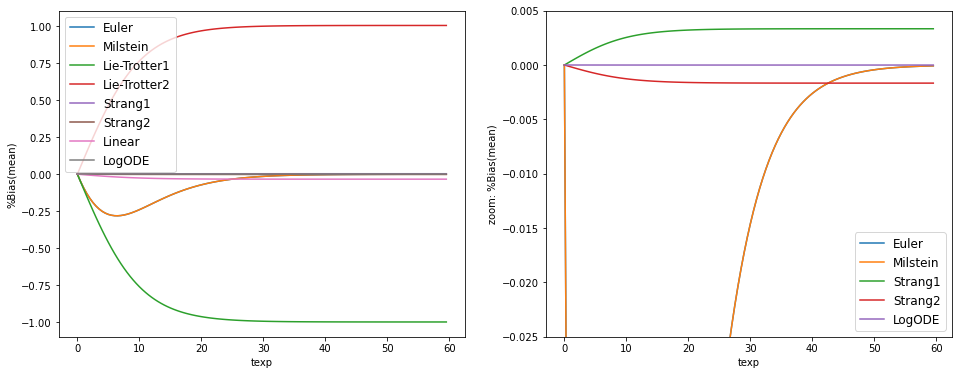

In [100]:
# Figure 1
sigma_0 = 10
dt = 0.1
mr = 0.2
theta = 5
vov = 0.2
texp_arr = np.arange(0, 60, 0.5)

mean_theo = np.zeros(len(texp_arr))
var_theo = np.zeros(len(texp_arr))
mean_error = np.zeros((len(scheme_dict),len(texp_arr)))
var_error = np.zeros((len(scheme_dict),len(texp_arr)))

igbm_theo = IGBM_theoretical(mr, theta, vov)
for i,texp in enumerate(texp_arr):
    mean_theo[i] = igbm_theo.cond_mean(sigma_0,texp)
    var_theo[i] = igbm_theo.cond_var(sigma_0,texp)

for scheme in scheme_dict:
    igbm_numer = IGBM_numerical(mr, theta, vov)

    for i,texp in enumerate(texp_arr):
        var_t = igbm_numer.cond_mean(sigma_0, texp, dt, scheme)
        mean_error[scheme][i] = (var_t - mean_theo[i]) / mean_theo[i] * 100
        
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
for scheme in scheme_dict:
    plt.plot(texp_arr, mean_error[scheme],label=scheme_dict[scheme])

plt.xlabel('texp')
plt.ylabel('%Bias(mean)')

plt.legend(loc=0,fontsize='large')

plt.subplot(1,2,2)
for scheme in [0,1,4,5,7]:
    plt.plot(texp_arr, mean_error[scheme],label=scheme_dict[scheme])
plt.ylim([-0.025,0.005])
plt.xlabel('texp')
plt.ylabel('zoom: %Bias(mean)')

plt.legend(loc=0,fontsize='large')
plt.show()

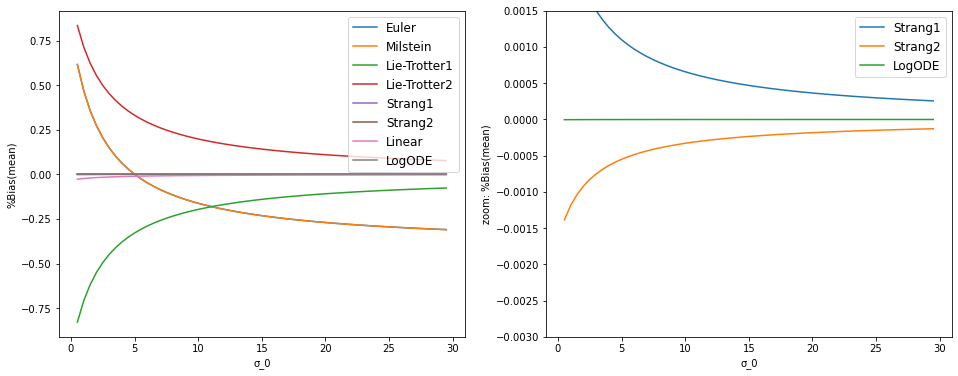

In [101]:
# Figure 2
sigma_arr = np.arange(0.5,30,0.5)
dt = 0.1
mr = 0.2
theta = 5
vov = 0.2
texp = 2

mean_theo = np.zeros(len(sigma_arr))
var_theo = np.zeros(len(sigma_arr))
mean_error = np.zeros((len(scheme_dict),len(sigma_arr)))
var_error = np.zeros((len(scheme_dict),len(sigma_arr)))

igbm_theo = IGBM_theoretical(mr, theta, vov)
for i,sigma_0 in enumerate(sigma_arr):
    mean_theo[i] = igbm_theo.cond_mean(sigma_0,texp)
    var_theo[i] = igbm_theo.cond_var(sigma_0,texp)

for scheme in scheme_dict:
    igbm_numer = IGBM_numerical(mr, theta, vov)

    for i,sigma_0 in enumerate(sigma_arr):
        var_t = igbm_numer.cond_mean(sigma_0, texp, dt, scheme)
        mean_error[scheme][i] = (var_t - mean_theo[i]) / mean_theo[i] * 100
        
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
for scheme in scheme_dict:
    plt.plot(sigma_arr, mean_error[scheme],label=scheme_dict[scheme])

plt.xlabel('σ_0')
plt.ylabel('%Bias(mean)')

plt.legend(loc=0,fontsize='large')

plt.subplot(1,2,2)
for scheme in [4,5,7]:
    plt.plot(sigma_arr, mean_error[scheme],label=scheme_dict[scheme])
plt.ylim([-0.003,0.0015])
plt.xlabel('σ_0')
plt.ylabel('zoom: %Bias(mean)')

plt.legend(loc=0,fontsize='large')
plt.show()

## 2.5 Monte-Carlo Biases of conditional mean and variance

Above is just the theoretical numerical error of the eight schemes. We also need to evaluation the actual MC simulation error, which is shown below. 

### 2.5.1 Figure 1 - Different time to expriy

In [102]:
# Figure 1 - MC simulation
sigma_0 = 10
dt = 0.1
mr = 0.2
theta = 5
vov = 0.2
texp_arr = np.arange(0.5, 60, 0.5)

mean_theo = np.zeros(len(texp_arr))
var_theo = np.zeros(len(texp_arr))
mean_error = np.zeros((len(scheme_dict),len(texp_arr)))
var_error = np.zeros((len(scheme_dict),len(texp_arr)))

igbm_theo = IGBM_theoretical(mr, theta, vov)
for i,texp in enumerate(texp_arr):
    mean_theo[i] = igbm_theo.cond_mean(sigma_0,texp)
    var_theo[i] = igbm_theo.cond_var(sigma_0,texp)

for scheme in scheme_dict:
    igbm = garch_2.GarchMcTubikanec2020(sigma_0,vov=vov,mr=mr,theta=theta)
    igbm.set_mc_params(n_path=1000000, dt=dt, rn_seed=None, antithetic=False, scheme=scheme)
    var_arr = igbm.cond_sequence(sigma_0,texp)

    for i,texp in enumerate(texp_arr):
        var_t = var_arr[int(texp/dt)]
        mean = np.mean(var_t)
        var = np.var(var_t)
        mean_error[scheme][i] = (mean - mean_theo[i]) / mean_theo[i] * 100
        var_error[scheme][i] = (var - var_theo[i]) / var_theo[i] * 100

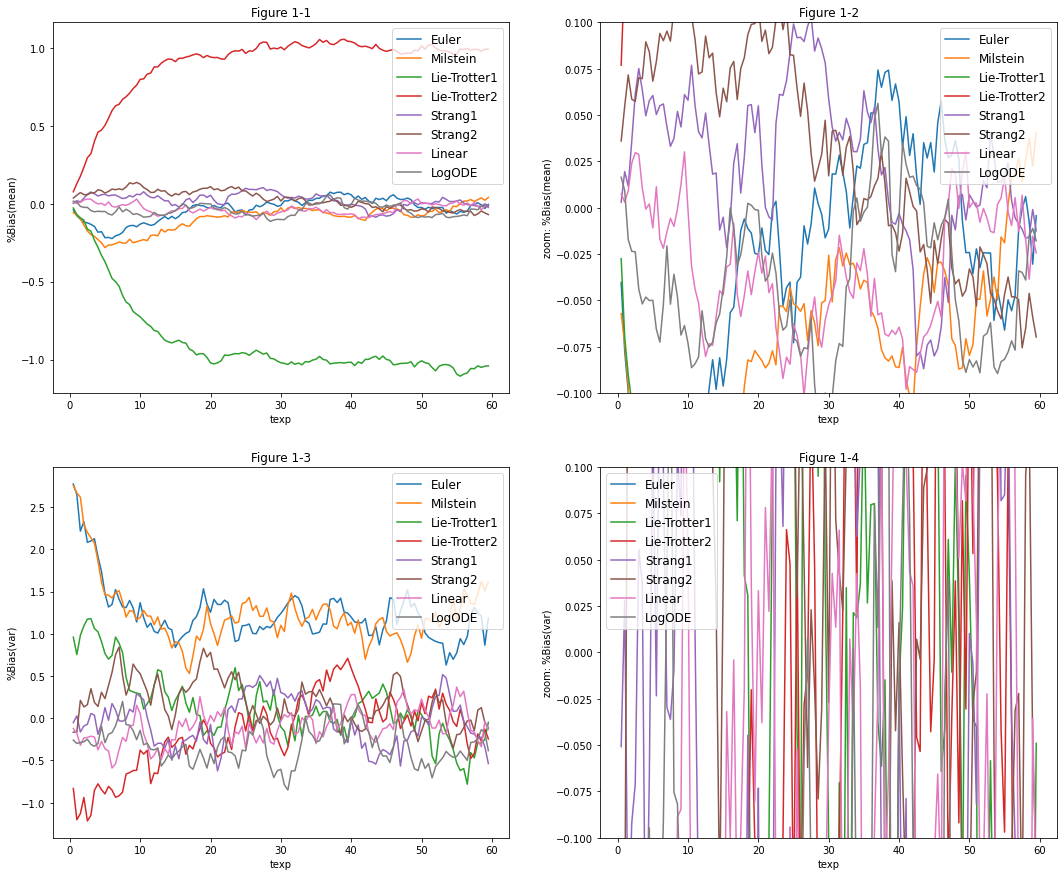

In [103]:
plt.figure(figsize=(18,15))
plt.subplot(2,2,1)
for scheme in scheme_dict:
    plt.plot(texp_arr, mean_error[scheme],label=scheme_dict[scheme])

plt.xlabel('texp')
plt.ylabel('%Bias(mean)')

plt.legend(loc=0,fontsize='large')
plt.title('Figure 1-1')

plt.subplot(2,2,2)
for scheme in scheme_dict:
    plt.plot(texp_arr, mean_error[scheme],label=scheme_dict[scheme])
plt.ylim([-0.1,0.1])
plt.xlabel('texp')
plt.ylabel('zoom: %Bias(mean)')

plt.legend(loc=0,fontsize='large')
plt.title('Figure 1-2')

plt.subplot(2,2,3)
for scheme in scheme_dict:
    plt.plot(texp_arr, var_error[scheme],label=scheme_dict[scheme])

plt.xlabel('texp')
plt.ylabel('%Bias(var)')

plt.legend(loc=0,fontsize='large')
plt.title('Figure 1-3')

plt.subplot(2,2,4)
for scheme in scheme_dict:
    plt.plot(texp_arr, var_error[scheme],label=scheme_dict[scheme])
plt.ylim([-0.1,0.1])
plt.xlabel('texp')
plt.ylabel('zoom: %Bias(var)')

plt.legend(loc=0,fontsize='large')
plt.title('Figure 1-4')

plt.show()

### 2.5.2 Figure 2 - Different initial $\sigma_0$

In [57]:
# Figure 2 - MC simulation
sigma_arr = np.arange(0.5,30,0.5)
dt = 0.1
mr = 0.2
theta = 5
vov = 0.2
texp = 2

mean_theo = np.zeros(len(sigma_arr))
var_theo = np.zeros(len(sigma_arr))
mean_error = np.zeros((len(scheme_dict),len(sigma_arr)))
var_error = np.zeros((len(scheme_dict),len(sigma_arr)))

igbm_theo = IGBM_theoretical(mr, theta, vov)
for i,sigma_0 in enumerate(sigma_arr):
    mean_theo[i] = igbm_theo.cond_mean(sigma_0,texp)
    var_theo[i] = igbm_theo.cond_var(sigma_0,texp)

for scheme in scheme_dict:
    igbm = garch_2.GarchMcTubikanec2020(sigma_arr,vov=vov,mr=mr,theta=theta)
    igbm.set_mc_params(n_path=100000, dt=dt, rn_seed=None, antithetic=True, scheme=scheme)

    for i,sigma_0 in enumerate(sigma_arr):
        vol_t, mean_var, mean_vol, mean_inv_vol = igbm.cond_states(sigma_0,texp)
        var_t = vol_t ** 2
        mean = np.mean(var_t)
        var = np.var(var_t)
        mean_error[scheme][i] = (mean - mean_theo[i]) / mean_theo[i] * 100
        var_error[scheme][i] = (var - var_theo[i]) / var_theo[i] * 100

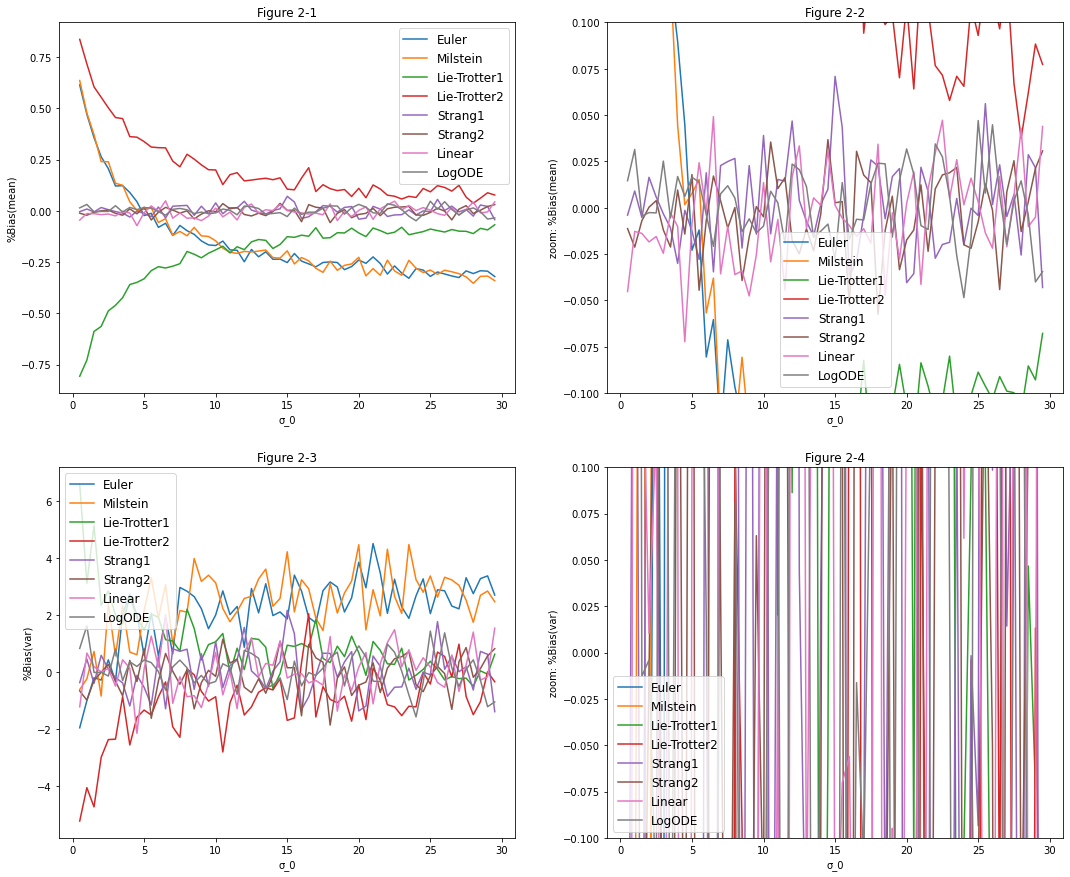

In [58]:
plt.figure(figsize=(18,15))
plt.subplot(2,2,1)
for scheme in scheme_dict:
    plt.plot(sigma_arr, mean_error[scheme],label=scheme_dict[scheme])

plt.xlabel('σ_0')
plt.ylabel('%Bias(mean)')

plt.legend(loc=0,fontsize='large')
plt.title('Figure 2-1')

plt.subplot(2,2,2)
for scheme in scheme_dict:
    plt.plot(sigma_arr, mean_error[scheme],label=scheme_dict[scheme])
plt.ylim([-0.1,0.1])
plt.xlabel('σ_0')
plt.ylabel('zoom: %Bias(mean)')

plt.legend(loc=0,fontsize='large')
plt.title('Figure 2-2')

plt.subplot(2,2,3)
for scheme in scheme_dict:
    plt.plot(sigma_arr, var_error[scheme],label=scheme_dict[scheme])

plt.xlabel('σ_0')
plt.ylabel('%Bias(var)')

plt.legend(loc=0,fontsize='large')
plt.title('Figure 2-3')

plt.subplot(2,2,4)
for scheme in scheme_dict:
    plt.plot(sigma_arr, var_error[scheme],label=scheme_dict[scheme])
plt.ylim([-0.1,0.1])
plt.xlabel('σ_0')
plt.ylabel('zoom: %Bias(var)')

plt.legend(loc=0,fontsize='large')
plt.title('Figure 2-4')

plt.show()

## 2.6 Comparing Different Schemes in Option Pricing

Finally we are about to use these 8 schemes of IGBM simulation to price various options. In this part we will compair these schemes in the following aspects:
- Variance at a particular n_path 
- Convergent speed as n_path increases
- Executing time

In [79]:
class GarchTest(garch_2.GarchMcTubikanec2020):
    def price_mean_std(self, strike, spot, texp, cp=1, times=100):
        price_arr = np.zeros(times)
        for t in range(times):
            price_arr[t] = self.price(strike, spot, texp)
        return np.mean(price_arr),np.std(price_arr)

### 2.6.1 Different time to expiry, n_path = 1000

In [80]:
spot = 100
strike = 120
sigma_0 = 0.2
dt = 0.05
mr = 0.2
theta = 5
vov = 0.2
texp_arr = np.arange(1, 10, 1)

price_mean_arr = np.zeros((len(scheme_dict),len(texp_arr)))
price_std_arr = np.zeros((len(scheme_dict),len(texp_arr)))

for scheme in scheme_dict:
    igbm = GarchTest(sigma_0,vov=vov,mr=mr,theta=theta)
    igbm.set_mc_params(n_path=1000, dt=dt, rn_seed=None, antithetic=False, scheme=scheme)
    for i,texp in enumerate(texp_arr):
        price_mean, price_std = igbm.price_mean_std(strike, spot, texp)
        price_mean_arr[scheme][i] = price_mean
        price_std_arr[scheme][i] = price_std

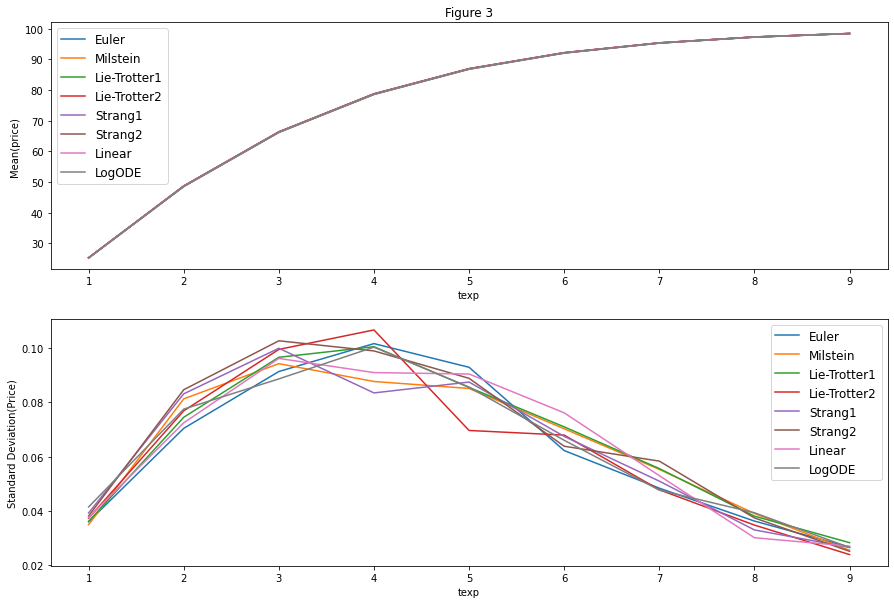

In [81]:
plt.figure(figsize=(15,10))
plt.subplot(2,1,1)
plt.title('Figure 3')
for scheme in scheme_dict:
    plt.plot(texp_arr, price_mean_arr[scheme],label=scheme_dict[scheme])

plt.xlabel('texp')
plt.ylabel('Mean(price)')

plt.legend(loc=0,fontsize='large')

plt.subplot(2,1,2)
for scheme in scheme_dict:
    plt.plot(texp_arr, price_std_arr[scheme],label=scheme_dict[scheme])
    
plt.xlabel('texp')
plt.ylabel('Standard Deviation(Price)')

plt.legend(loc=0,fontsize='large')

plt.show()

### 2.6.2 Different initial sigma, n_path = 1000

In [82]:
spot = 100
strike = 120
sigma_arr = np.arange(0.01,0.5,0.01)
dt = 0.05
mr = 0.2
theta = 5
vov = 0.2
texp = 2

price_mean_arr = np.zeros((len(scheme_dict),len(sigma_arr)))
price_std_arr = np.zeros((len(scheme_dict),len(sigma_arr)))

for scheme in scheme_dict:
    for i,sigma_0 in enumerate(sigma_arr):
        igbm = GarchTest(sigma_0,vov=vov,mr=mr,theta=theta)
        igbm.set_mc_params(n_path=1000, dt=dt, rn_seed=None, antithetic=False, scheme=scheme)
        price_mean, price_std = igbm.price_mean_std(strike, spot, texp)
        price_mean_arr[scheme][i] = price_mean
        price_std_arr[scheme][i] = price_std

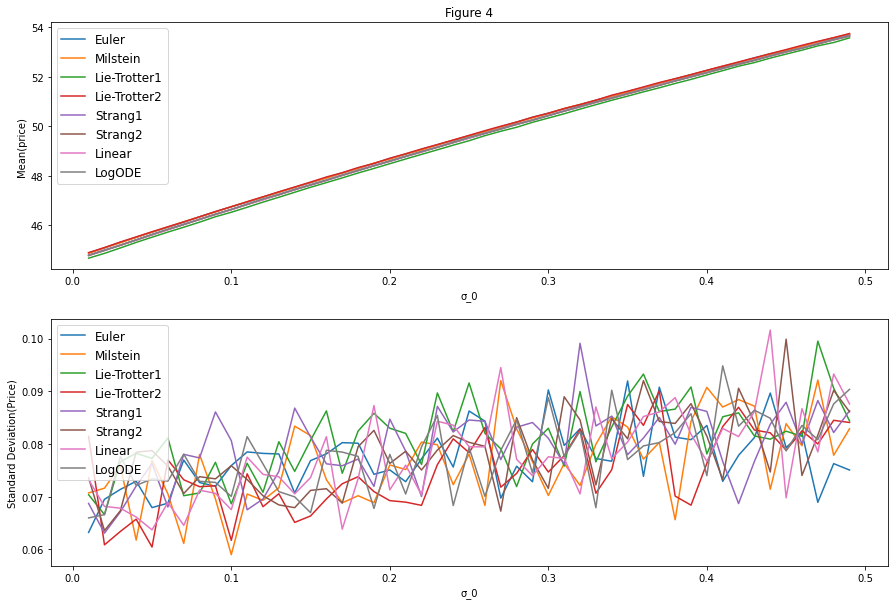

In [83]:
plt.figure(figsize=(15,10))
plt.subplot(2,1,1)
plt.title('Figure 4')
for scheme in scheme_dict:
    plt.plot(sigma_arr, price_mean_arr[scheme],label=scheme_dict[scheme])

plt.xlabel('σ_0')
plt.ylabel('Mean(price)')

plt.legend(loc=0,fontsize='large')

plt.subplot(2,1,2)
for scheme in scheme_dict:
    plt.plot(sigma_arr, price_std_arr[scheme],label=scheme_dict[scheme])
    
plt.xlabel('σ_0')
plt.ylabel('Standard Deviation(Price)')

plt.legend(loc=0,fontsize='large')

plt.show()

### 2.6.3 Different strikes, n_path = 1000

In [84]:
spot = 100
strike_arr = np.arange(30,170,1)
sigma_0 = 0.2
dt = 0.05
mr = 0.2
theta = 5
vov = 0.2
texp = 2

price_mean_arr = np.zeros((len(scheme_dict),len(strike_arr)))
price_std_arr = np.zeros((len(scheme_dict),len(strike_arr)))

for scheme in scheme_dict:
    igbm = GarchTest(sigma_0,vov=vov,mr=mr,theta=theta)
    igbm.set_mc_params(n_path=1000, dt=dt, rn_seed=None, antithetic=False, scheme=scheme)
    for i,strike in enumerate(strike_arr):
        price_mean, price_std = igbm.price_mean_std(strike, spot, texp)
        price_mean_arr[scheme][i] = price_mean
        price_std_arr[scheme][i] = price_std

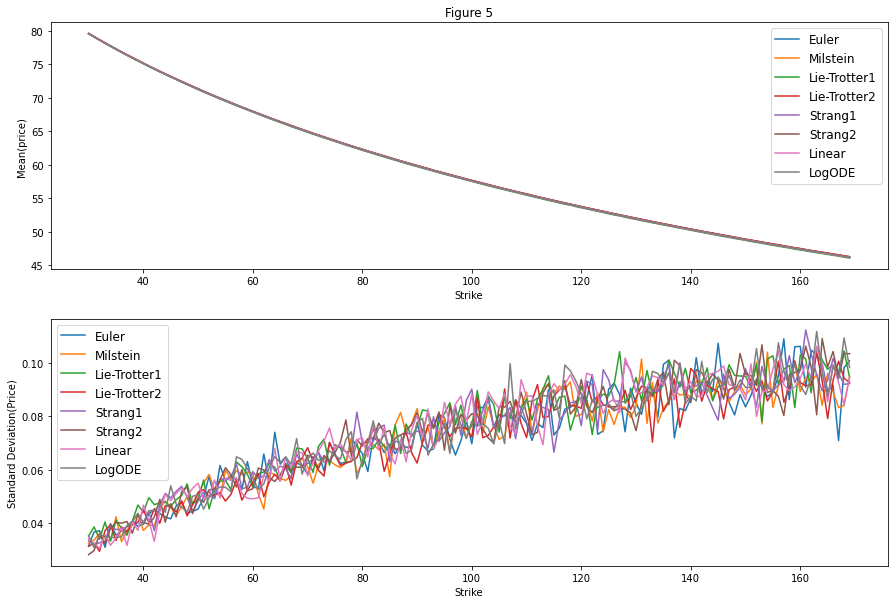

In [85]:
plt.figure(figsize=(15,10))
plt.subplot(2,1,1)
plt.title('Figure 5')
for scheme in scheme_dict:
    plt.plot(strike_arr, price_mean_arr[scheme],label=scheme_dict[scheme])

plt.xlabel('Strike')
plt.ylabel('Mean(price)')

plt.legend(loc=0,fontsize='large')

plt.subplot(2,1,2)
for scheme in scheme_dict:
    plt.plot(strike_arr, price_std_arr[scheme],label=scheme_dict[scheme])
    
plt.xlabel('Strike')
plt.ylabel('Standard Deviation(Price)')

plt.legend(loc=0,fontsize='large')

plt.show()

### 2.6.4 Convergence Speed

In [86]:
spot = 100
strike_arr = 120
sigma_0 = 0.2
dt = 0.05
mr = 0.2
theta = 5
vov = 0.2
texp = 2
path_arr = np.power(10,np.arange(1,5,1)).astype(int)

price_mean_arr = np.zeros((len(scheme_dict),len(path_arr)))
price_std_arr = np.zeros((len(scheme_dict),len(path_arr)))

for scheme in scheme_dict:
    for i,n in enumerate(path_arr):
        igbm = GarchTest(sigma_0,vov=vov,mr=mr,theta=theta)
        igbm.set_mc_params(n_path=n, dt=dt, rn_seed=None, antithetic=False, scheme=scheme)
        price_mean, price_std = igbm.price_mean_std(strike, spot, texp)
        price_mean_arr[scheme][i] = price_mean
        price_std_arr[scheme][i] = price_std

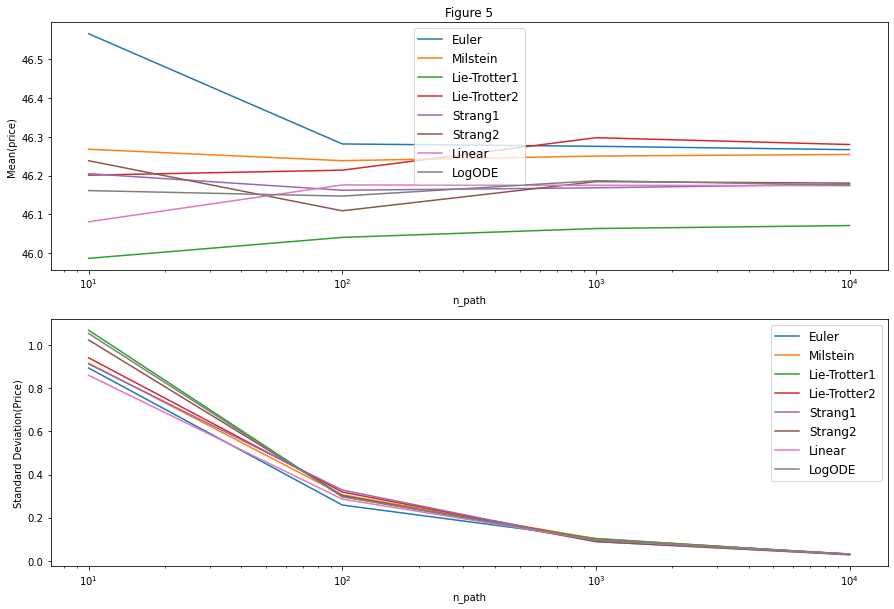

In [87]:
plt.figure(figsize=(15,10))
plt.subplot(2,1,1)
plt.title('Figure 5')
for scheme in scheme_dict:
    plt.plot(path_arr, price_mean_arr[scheme],label=scheme_dict[scheme])
    
plt.xscale('log')
plt.xlabel('n_path')
plt.ylabel('Mean(price)')

plt.legend(loc=0,fontsize='large')

plt.subplot(2,1,2)
for scheme in scheme_dict:
    plt.plot(path_arr, price_std_arr[scheme],label=scheme_dict[scheme])

plt.xscale('log')
plt.xlabel('n_path')
plt.ylabel('Standard Deviation(Price)')

plt.legend(loc=0,fontsize='large')

plt.show()

### 2.6.5 Executing Time, n_path = 1000

In [91]:
spot = 100
strike = 120
sigma_0 = 0.2
dt = 0.05
mr = 0.2
theta = 5
vov = 0.2
texp = 2

scheme_time = []

for scheme in scheme_dict:
    t_0 = time.time()
    igbm = garch_2.GarchMcTubikanec2020(sigma_0,vov=vov,mr=mr,theta=theta)
    igbm.set_mc_params(n_path=1000, dt=dt, rn_seed=None, antithetic=False, scheme=scheme)
    for t in range(100):
        price = igbm.price(strike, spot, texp)
    t_1 = time.time()
    avg_time = (t_1 - t_0) / 100
    scheme_time.append(avg_time)

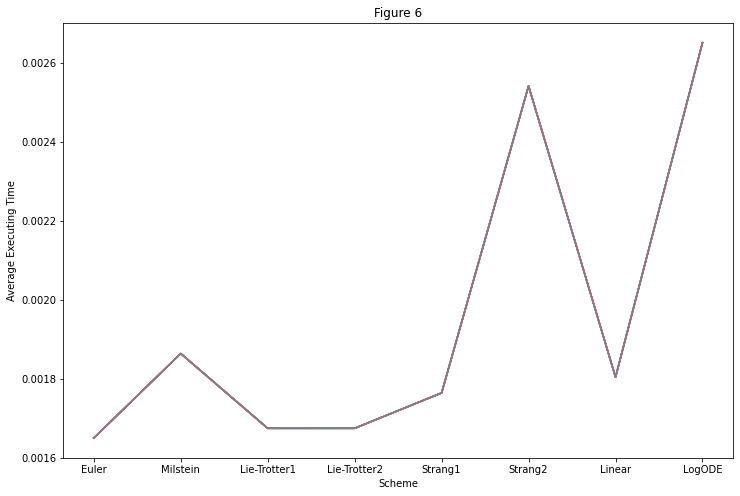

In [92]:
plt.figure(figsize=(12,8))
plt.title('Figure 6')
for scheme in scheme_dict:
    plt.plot(scheme_dict.values(), scheme_time,label=scheme_dict[scheme])
plt.xlabel('Scheme')
plt.ylabel('Average Executing Time')
plt.show()